In [172]:
import numpy as np
import torch
import os
import sympy as sp
import matplotlib.pyplot as plt
import time as time

# Device 
print("Versión de PyTorch:", torch.__version__)
print("CUDA disponible?:", torch.cuda.is_available())
print("MPS disponible?:", torch.backends.mps.is_available())

if torch.backends.mps.is_available():
    device = torch.device("mps")        # GPU Apple Silicon
    print("Usando GPU MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")       # Para PCs con NVIDIA
    print("Usando GPU CUDA")
else:
    device = torch.device("cpu")
    print("Usando CPU")

device = torch.device("cpu")  # Forzar uso de CPU
device

Versión de PyTorch: 2.1.0
CUDA disponible?: False
MPS disponible?: True
Usando GPU MPS


device(type='cpu')

In [173]:
import torch
print(torch.__version__)
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())


2.1.0
True
True


# Ecuación de Poisson

In [174]:
# Definiendo una semilla para reproducibilidad
def set_seed(seed = 88):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    torch.use_deterministic_algorithms(True, warn_only=True)

set_seed()

Considere el siguiente problema: Hallar $u=u(x,y)$, satisfaciendo:

$$\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} + 2\pi^2 \sin(\pi x)\sin(\pi y) = 0$$
sobre $\Omega = (1,0)\times(1,0)$, y con la condición $u=0$ sobre todo el borde de $\Omega$. 

La solucion del problema anterior viene dada por:
$$u(x,y) = \sin(\pi x)\sin(\pi y).$$ 

In [175]:
def f_np(x,y):
    '''Función fuente para la ecuación de Poisson.'''
    return 2*np.pi**2 * np.sin(np.pi*x)*np.sin(np.pi*y)

def f_th(x,y):
    '''Función fuente para la ecuación de Poisson.'''
    return 2*torch.pi**2 * torch.sin(torch.pi*x)*torch.sin(torch.pi*y)

In [176]:
# Verificación de la solución analítica
x, y = sp.symbols('x, y')

f_sp = 2*sp.pi**2 * sp.sin(sp.pi*x)*sp.sin(sp.pi*y)
u_sp = sp.sin(sp.pi*x)*sp.sin(sp.pi*y)

Poisson_eq = sp.diff(u_sp, x, 2) + sp.diff(u_sp, y, 2) + f_sp
print(Poisson_eq.simplify())

del x, y 

0


In [177]:
# Solución del problema anterior
def u_exact(x,y):
    '''Solución exacta de la ecuación de Poisson.'''
    return np.sin(np.pi*x)*np.sin(np.pi*y)

## A Plain PINN Class

In [178]:
class PINN2D(torch.nn.Module):
    def __init__(self, Nn, NL, actit = torch.tanh):
        super(PINN2D, self).__init__()
        self.actit = actit
        self.hidden = torch.nn.ModuleList([torch.nn.Linear(2, Nn)])
        self.hidden.extend([torch.nn.Linear(Nn,Nn) for _ in range(NL-1)])
        self.out = torch.nn.Linear(Nn,1)

        self.to(device)
    
    def forward(self, x):
        z = x
        for layer in self.hidden:
            z = self.actit(layer(z))
        return self.out(z)
        

In [179]:
def count_parameters(pinn):
    ''' Compute the total number of trainable parameters for an NN pinn'''
    return sum(p.numel() for p in pinn.parameters() if p.requires_grad)

def print_model_params(pinn, print_table = True):
    P_total = 0
    P_star = 0

    if print_table:
        print(f"{'Layer':<20}{'Param Shape':<15}{'# params':<15}"
              f"{'affine_dim':<15}")
        print("-" * 61)
    
    for name, param in pinn.named_parameters():
        if param.requires_grad:
            affin_dim = 0
            if param.dim() == 2:
                affin_dim = param.size(1)
            elif param.dim() == 1:
                affin_dim = 1

            P_star += affin_dim
            num_params = param.numel()
            P_total += num_params

            if print_table:
                print(f'{name:<20}{str(list(param.shape)):<15}'
                      f'{num_params:<15}{affin_dim}')
    
    if print_table:
        print("-" * 61)
    
    print(f'P*(Total pseudo-dimension of the affine space) = {P_star}')
    print(f'Total trainable parameters: {P_total}')

    return P_star, P_total

In [180]:
p = 2
Nn = 50
NL = 2
P_star = (p+1) + (Nn +1) * NL

print(f"P* (Total pseudo-dimension of affine space) = {P_star}")


P* (Total pseudo-dimension of affine space) = 105


In [181]:
pinn = PINN2D(Nn, NL)
P_star, P_total = print_model_params(pinn)

Layer               Param Shape    # params       affine_dim     
-------------------------------------------------------------
hidden.0.weight     [50, 2]        100            2
hidden.0.bias       [50]           50             1
hidden.1.weight     [50, 50]       2500           50
hidden.1.bias       [50]           50             1
out.weight          [1, 50]        50             50
out.bias            [1]            1              1
-------------------------------------------------------------
P*(Total pseudo-dimension of the affine space) = 105
Total trainable parameters: 2751


## PINN class with DNC enforced

In [182]:
class PINN2D_4DBC(torch.nn.Module):
    def __init__(self, Nn, NL, actit = torch.tanh, a=0., b=1., c=0., d=1.):
        super(PINN2D_4DBC, self).__init__()
        self.actit = actit
        self.a = torch.tensor(a, dtype=torch.float32)
        self.b = torch.tensor(b, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)
        self.d = torch.tensor(d, dtype=torch.float32)

        self.hidden = torch.nn.ModuleList([torch.nn.Linear(2, Nn)])
        self.hidden.extend([torch.nn.Linear(Nn,Nn) for _ in range(NL-1)])
        self.out = torch.nn.Linear(Nn,1)

        self.to(device)
    
    def forward(self, x):
        x_ = x[:,0:1]
        y_ = x[:,1:2]
    
        # Generalized zero-DBC trial multiplier
        #f_DBC = (x_ - self.a)*(self.b - x_)*(y_ - self.c)*(self.d - y_)

        z = x
        for layer in self.hidden:
            z = self.actit(layer(z))
        N = self.out(z)
        u_trial =  N
        return u_trial

In [183]:
pinn2d_4dbc = PINN2D_4DBC(Nn, NL)

In [184]:
xx = torch.tensor([[0.0,0.5]], dtype=torch.float32).to(device)

In [185]:
pinn2d_4dbc(xx)

tensor([[0.1133]], grad_fn=<AddmmBackward0>)

## Residual Evaluation via collocation points

In [186]:
def laplacian(u, xy):
    grads = torch.autograd.grad(u, xy, torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0:1]
    u_y = grads[:, 1:2]

    u_xx = torch.autograd.grad(u_x, xy, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(u_y, xy, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]

    return u_xx + u_yy #, grads, u_x, u_y, u_xx, u_yy

In [187]:
x_test = torch.tensor([[0.0,0.5]], dtype=torch.float32)
x_test.requires_grad = True

laplacian(pinn2d_4dbc(x_test), x_test)

tensor([[-0.0058]], grad_fn=<AddBackward0>)

In [188]:
def residual_clctn(pinn, f_th, x, weights = None, x_NBC = None, t_NBC = None):
    u_pred = pinn(x)
    lap_u = laplacian(u_pred, x)

    x1 = x[:,0:1]
    x2 = x[:,1:2]

    residuals = (lap_u - f_th(x1, x2))**2
    return torch.mean(residuals), residuals

## Generation of Collocation Points in Rectangule

In [189]:
def sampleD_clctn(N_clctn = 1500, a=0.0, b=1.0, c=0.0, d=1.0):
    ''' Generate collocation points in a rectangle [a,b]x[c,d] '''

    x_vals = np.random.uniform(a, b, N_clctn)
    y_vals = np.random.uniform(c, d, N_clctn)
    x_omega = np.vstack((x_vals, y_vals)).T

    x_omega = torch.tensor(x_omega, dtype=torch.float32, requires_grad=True)
    return x_omega


In [190]:
def sample4DBC_rect(NBC = 20, a = 0.0, b = 1.0, c = 0.0, d = 1.0):
    ''' Generate boundary points for 4-DBC in a rectangle [a,b]x[c,d] '''

    x_DBCs = []
    x_DBCs.extend([[x_i, c] for x_i in np.linspace(a, b, NBC)])  # Bottom
    x_DBCs.extend([[x_i, d] for x_i in np.linspace(a, b, NBC)])  # Top
    x_DBCs.extend([[a, y_i] for y_i in np.linspace(c, d, NBC)])  # Left
    x_DBCs.extend([[b, y_i] for y_i in np.linspace(c, d, NBC)])  # Right

    x_DBC = np.unique(np.array(x_DBCs), axis = 0)
    u_DBC = np.zeros((x_DBC.shape[0], 1))

    x_DBC_th = torch.tensor(x_DBC, dtype=torch.float32, requires_grad=True)
    u_DBC_th = torch.tensor(u_DBC, dtype=torch.float32)

    return x_DBC_th, u_DBC_th

In [191]:
def plotSamplePointRect(x_omega, x_DBC, a = 0.0, b= 1.0, c= 0.0, d=1.0, dpi = 200, f_name = 'tmp.png'):

    x_omega = x_omega.detach().numpy()
    x_DBC = x_DBC.detach().numpy()
    
    fig, ax = plt.subplots(figsize=(3,3), dpi = dpi)
    ax.scatter(x_omega[:,0], x_omega[:,1], c='blue', s=1, label='Collocation Points')
    ax.scatter(x_DBC[:,0], x_DBC[:,1], c='red', s=2, label='Boundary Points')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Points in [{a},{b}]x[{c},{d}] and Boundary')
    ax.set_aspect('equal')
    plt.legend()
    plt.savefig(f_name, dpi = 500)
    plt.show()
    plt.close(fig)

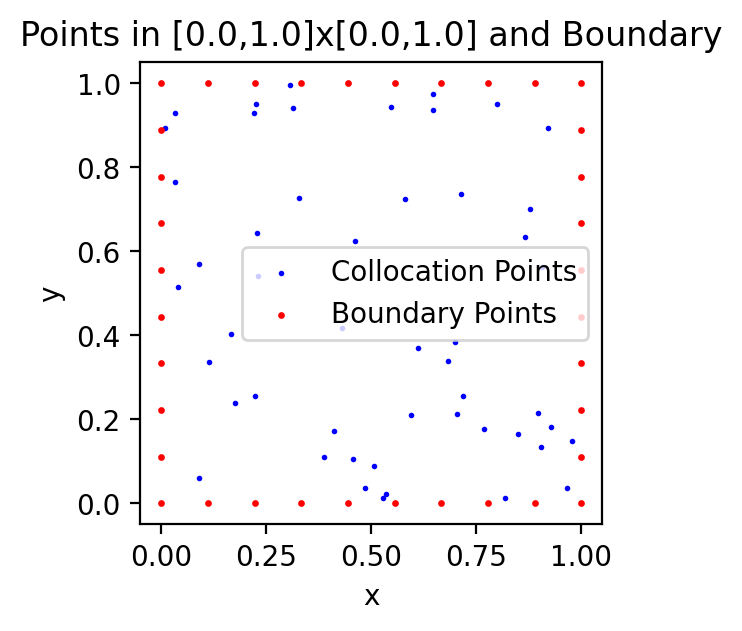

In [192]:
a = 0.0; b= 1.0; c= 0.0; d=1.0
N_sample = 50
x_omega = sampleD_clctn(N_sample, a, b, c, d)
x_DBC, u_DBC = sample4DBC_rect(10, a, b, c, d)
plotSamplePointRect(x_omega, x_DBC)

## Trainer for PDE

In [193]:
def trainerPDE_DBC(pinn, residual, optimizer, f_th, x_omega_th, x_DBC_th, u_DBC_th,
                   N_epochs = 1000):
    loss_history = {
                    'Total': [],
                    'PDE': [],
                    'DBC': []
                    }

    for epoch in range(N_epochs):
        loss_PDE = None; loss_DBC = None; total_loss = None

        def closure():
            nonlocal loss_PDE, loss_DBC, total_loss #modificas las variables de afuera de la funcion 

            optimizer.zero_grad()
            
            loss_PDE, _ = residual(pinn, f_th, x_omega_th)
            u_DBC_pred = pinn(x_DBC_th)
            loss_DBC = torch.mean((u_DBC_th - u_DBC_pred)**2)
            
            total_loss = loss_PDE + loss_DBC
            total_loss.backward()
            return total_loss

        if isinstance(optimizer, torch.optim.LBFGS):
            optimizer.step(closure)
            total_loss_val = total_loss.item()
            loss_PDE_val = loss_PDE.item()
            loss_DBC_val = loss_DBC.item()
        else:
            total_loss_tensor = closure()
            optimizer.step()
            total_loss_val = total_loss_tensor.item()
            loss_PDE_val = loss_PDE.item()
            loss_DBC_val = loss_DBC.item()

        with torch.no_grad():
            loss_history['Total'].append(total_loss_val)
            loss_history['PDE'].append(loss_PDE_val)
            loss_history['DBC'].append(loss_DBC_val)
            
        if epoch % 100 == 0:
                print(f'Epoch {epoch+1}/{N_epochs}, Total Loss: {total_loss_val:.6e}, '
                      f'PDE Loss: {loss_PDE_val:.6e}, DBC Loss: {loss_DBC_val:.6e}')

    return loss_history

In [194]:
pinn2d = PINN2D(Nn, NL)

In [195]:
optim = torch.optim.Adam(pinn2d.parameters(), lr=0.001)
optim = torch.optim.LBFGS(pinn2d.parameters(), lr=0.1, max_iter=50000, max_eval=50000,
                          tolerance_grad=1e-09, tolerance_change=1e-09, history_size=50, line_search_fn='strong_wolfe')

In [196]:
#hist = trainerPDE_DBC(pinn2d, residual_clctn, optim, f_th, x_omega, x_DBC, u_DBC, N_epochs = 1000)

In [197]:
def train_adam_lbfgs(pinn, trainer, residual, f_th, x_omega, x_DBC, u_DBC,
                     epochs_adam = 201, epochs_lbfgs = 11, use_lbfgs = True):
    

    star_time = time.perf_counter()

    adam = torch.optim.Adam(pinn.parameters(), lr=0.001)
    print("="*50)
    print(f"{epochs_adam} epochs with Adam optimizer")

    history_adam = trainer(pinn, residual, adam, f_th, x_omega, x_DBC, u_DBC,
                           N_epochs = epochs_adam)
    
    end_time = time.perf_counter()
    time_adam = end_time - star_time
    print(f"Tiempo de entrenamiento con Adam: {time_adam:.2f} segundos")

    if use_lbfgs:
        star_time = time.perf_counter()

        lbfgs_optimizer = torch.optim.LBFGS(pinn.parameters(), lr=0.1, max_iter=500,
                                            tolerance_grad=1e-09, tolerance_change=1e-09,
                                           history_size=100, line_search_fn='strong_wolfe')
        print("="*50)
        print(f"{epochs_lbfgs} epochs with LBFGS optimizer")

        history_lbfgs = trainer(pinn, residual, lbfgs_optimizer, f_th, x_omega, x_DBC, u_DBC,
                               N_epochs = epochs_lbfgs)
        
        print(f"\nTraining complete")
        end_time = time.perf_counter()
        time_lbfgs = end_time - star_time
        print(f"Tiempo de entrenamiento con LBFGS: {time_lbfgs:.2f} segundos")
        totalTime = time_adam + time_lbfgs
        print(f"Tiempo total de entrenamiento: {totalTime:.2f} segundos")
        print(f"Ratio tiempo LBFGS/Adam: {time_lbfgs/time_adam:.2f}")

        return (history_adam, history_lbfgs), totalTime
    else:
        time_lbfgs = 0.0
        print(f"\nTraining complete")
        return history_adam, time_adam

## Case Study 

In [198]:
p = 2 
Nn = 50
NL = 2 

pinns = []
pinn = PINN2D(Nn, NL)
p_STAR, P_total = print_model_params(pinn)

a = 0.0; b= 1.0; c= 0.0; d=1.0
N_sample = 1*P_star
x_omega = sampleD_clctn(N_sample, a, b, c, d)
x_DBC, u_DBC = sample4DBC_rect(20, a, b, c, d)

print(f"Número de puntos de colacción: {x_omega.shape[0]}")
print(f"Is N_sample >= P*? {N_sample >= P_star}")
print(f"Número de puntos de frontera: {x_DBC.shape[0]}")

Layer               Param Shape    # params       affine_dim     
-------------------------------------------------------------
hidden.0.weight     [50, 2]        100            2
hidden.0.bias       [50]           50             1
hidden.1.weight     [50, 50]       2500           50
hidden.1.bias       [50]           50             1
out.weight          [1, 50]        50             50
out.bias            [1]            1              1
-------------------------------------------------------------
P*(Total pseudo-dimension of the affine space) = 105
Total trainable parameters: 2751
Número de puntos de colacción: 105
Is N_sample >= P*? True
Número de puntos de frontera: 76


In [199]:
Trainers = []
Residuals = []
totalTimes = []
LossTerms = []
LossTerm = 'DBC'

Trainer = trainerPDE_DBC
Residual = residual_clctn

losses, totalTime = train_adam_lbfgs(pinn, Trainer, Residual, f_th, x_omega, x_DBC, u_DBC,
                                    epochs_adam = 2001, epochs_lbfgs = 500, use_lbfgs = True)

2001 epochs with Adam optimizer
Epoch 1/2001, Total Loss: 7.708575e+01, PDE Loss: 7.707750e+01, DBC Loss: 8.249505e-03
Epoch 101/2001, Total Loss: 6.452546e+00, PDE Loss: 4.914926e+00, DBC Loss: 1.537621e+00
Epoch 201/2001, Total Loss: 4.560620e-01, PDE Loss: 4.210130e-01, DBC Loss: 3.504900e-02
Epoch 301/2001, Total Loss: 1.985346e-01, PDE Loss: 1.673315e-01, DBC Loss: 3.120317e-02
Epoch 401/2001, Total Loss: 8.334377e-02, PDE Loss: 6.145867e-02, DBC Loss: 2.188510e-02
Epoch 501/2001, Total Loss: 5.341735e-02, PDE Loss: 3.702417e-02, DBC Loss: 1.639318e-02
Epoch 601/2001, Total Loss: 4.210198e-02, PDE Loss: 2.793635e-02, DBC Loss: 1.416563e-02
Epoch 701/2001, Total Loss: 3.604646e-02, PDE Loss: 2.277656e-02, DBC Loss: 1.326990e-02
Epoch 801/2001, Total Loss: 3.148899e-02, PDE Loss: 1.870134e-02, DBC Loss: 1.278765e-02
Epoch 901/2001, Total Loss: 2.767372e-02, PDE Loss: 1.529144e-02, DBC Loss: 1.238228e-02
Epoch 1001/2001, Total Loss: 2.440768e-02, PDE Loss: 1.243308e-02, DBC Loss: 1.1